This tutorial is licensed by [Bernard Koch](http://www.github.com/kochbj) under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/). The following tutorial is adapted based on the code provided by B.Koch, modifications and adaptations were done by me.

#  Using Integral Probability Metrics to Bound the Counterfactual Loss

Instead of using  semi-parametric corrections based on the propensity score to adjust ATE estimates, [Shalit et al., 2017](https://arxiv.org/abs/1606.03976), [Johansson et al. 2019](https://arxiv.org/abs/1903.03448), and [Johansson et al., 2020](https://arxiv.org/abs/2001.07426) take a different approach to encourage the representation function $\Phi$ to explicitly learn treatment effects: integral probability metrics. 

Integral probability metrics (IPMs) are true metrics (symmetric and obey the triangle inequality unlike KL divergence) that measure the distance between two distributions. **The key idea here is that we can add an IPM as a loss in TARNET to more explicitly encourage the representation layers to balance the covariate distribution of the treated group $T$, and the covariate distribution of the control group $C$.** In recent years, IPMs have become very popular losses for generative adversarial networks.   

Theoretically, this group has developed generalization bounds for the $CATE$ that show that even though the counterfactual loss is unknowable, it can be bounded by the factual loss of $h$ and an IPM between the treated and control distributions. Their claims focus on two IPMs in particular:

## Wasserstein Distance

The Wasserstein or “Earth Mover’s” distance fits an interpretable ”map” (i.e.  a matrix) showing how to efficiently convert from one probability mass distribution to another. The  Wasserstein  distance  is  most  easily  understood  as  an  optimal  transport  problem  (i.e., a scenario where we want to transport one distribution to another at minimum cost).  The nickname "Earth mover’s distance” comes from the metaphor of shoveling dirt to terraform one landscape into another.  In the idealized case in which one distribution can be perfectly transformed into another, the Wasserstein map corresponds exactly to a perfect one-to-one matching on covariates strategy ([Kallus, 2016](https://arxiv.org/abs/1612.08321)). Because calculating the Wasserstein distance requires optimizing the map, we'll focus on the computationally simpler Maximum Mean Discrepancy metric. 

## Maximum Mean Discrepancy (MMD)

The  maximum  mean  discrepancy (MMD)  is  the  normed  distance between the means of two distributions $T$ and $C$,  after a kernel function has transformed them into a high-dimensional reproducing kernel Hibbert Space (RKHS). It relies on the kernel trick to calculate distances in the RKHS. The metric is built on the intuition that there is no function that would have differing expected values for $T$ and $C$ in this high-dimensional space, if $T$ and $C$ are the same distribution. Formally we can define the MMD as

$$MMD(T,C) = ||\mathbb{E}_{X \sim T}\phi(X) - \mathbb{E}_{X \sim C}\phi(X)||^2_{\mathcal{H}}$$

where $\phi$ is associated with a reproducing kernel function $k$ such as the Gaussian radial basis function kernel: $$k(X,X')=\exp({- \frac{||X-X'||^2}{2\sigma^2} }) $$

From [Johansson et al., 2020](https://arxiv.org/abs/2001.07426), an unbiased estimator for the square of the MMD from a sample of size $m$ drawn from treated distribution $T$ and a sample of size $n$ drawn from control distribution $C$ is,

$$\hat{MMD}^2_k(T,C):=\frac{1}{m(m-1)}\sum_{i=1}^m\sum_{i=j}^mk(x_i^T,x_j^T)-\frac{2}{mn}\sum_{i=1}^m\sum_{i=j}^nk(x_i^T,x_j^C)+\frac{1}{n(n-1)}\sum_{i=1}^n\sum_{i=j}^nk(x_i^C,x_j^C)$$



## MMD, exercise
Compare the math and the code below. Map the python functions/variables to the corresponding math.
Create an instance of mmdq (Max Mean Discrepancy class), generate 1.000 samples from a normal distribution with loc=4,shape=1. Generate 1.000 samples from a gamma distribution with shape=20, scale=0.25. Calculate the MMD using the calc_mmdqs function. Check that MMD(N,G)=MMD(G,N). Write a for loop, keep all the parameters fixed and only change value of shape of the gamma. Change it in step of 1 from 1 to 20. Test for wich values of gamma shape the MMD is minimum when calculated with the N(4,1).

In [1]:
import tensorflow as tf
import numpy as np

def pdist2sq(x, y):
    x = tf.expand_dims(x, axis=1)  # (m,1)
    y = tf.expand_dims(y, axis=1)  # (n,1)
    x2 = tf.reduce_sum(x ** 2, axis=-1, keepdims=True)  # (m,1)
    y2 = tf.reduce_sum(y ** 2, axis=-1, keepdims=True)  # (n,1)
    dist = x2 + tf.transpose(y2) - 2. * tf.matmul(x, tf.transpose(y))
    return dist

class mmdq():
    def __init__(self, sigma=1.):
        super().__init__()
        self.rbf_sigma = sigma

    def rbf_kernel(self, x, y):
        return tf.exp(-pdist2sq(x, y) / tf.square(self.rbf_sigma))

    def calc_mmdsq(self, samples1, samples2):
        K11 = self.rbf_kernel(samples1, samples1)
        K12 = self.rbf_kernel(samples1, samples2)
        K22 = self.rbf_kernel(samples2, samples2)

        m = tf.cast(tf.shape(samples1)[0], samples1.dtype)
        n = tf.cast(tf.shape(samples2)[0], samples2.dtype)

        #  MMD^2 unbiased estimator
        mmd = 1.0 / (m * (m - 1.0)) * (tf.reduce_sum(K11) - tf.reduce_sum(tf.linalg.diag_part(K11)))
        mmd += 1.0 / (n * (n - 1.0)) * (tf.reduce_sum(K22) - tf.reduce_sum(tf.linalg.diag_part(K22)))
        mmd -= 2.0 / (m * n) * tf.reduce_sum(K12)
        return mmd

mmd_calc = mmdq(sigma=1.0)

np.random.seed(21727)  
normal_samples = np.random.normal(loc=4, scale=1, size=1000).astype(np.float32)

normal_samples_tf = tf.constant(normal_samples.reshape(-1,1), dtype=tf.float32)

mmd_results = []

print("Shape\tMMD(Normal, Gamma)\tMMD(Gamma, Normal)")


for shape_val in range(1, 21):
    gamma_samples = np.random.gamma(shape=shape_val, scale=0.25, size=1000).astype(np.float32)
    gamma_samples_tf = tf.constant(gamma_samples.reshape(-1,1), dtype=tf.float32)

    #  MMD(Normal, Gamma)
    mmd_ng = mmd_calc.calc_mmdsq(normal_samples_tf, gamma_samples_tf).numpy()

    #  MMD(Gamma, Normal) 
    mmd_gn = mmd_calc.calc_mmdsq(gamma_samples_tf, normal_samples_tf).numpy()

    print(f"{shape_val}\t{mmd_ng:.6f}\t\t{mmd_gn:.6f}")

    mmd_results.append((shape_val, mmd_ng))

# Min mmd
shape_min, mmd_min = min(mmd_results, key=lambda x: x[1])

print(f"\nMinimum MMD at gamma shape = {shape_min} with MMD = {mmd_min:.6f}")



2025-09-11 15:57:37.946293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757606258.065663    2740 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757606258.094531    2740 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757606258.318487    2740 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757606258.318523    2740 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757606258.318526    2740 computation_placer.cc:177] computation placer alr

Shape	MMD(Normal, Gamma)	MMD(Gamma, Normal)
1	1.332042		1.332042
2	1.254863		1.254863
3	1.162920		1.162920
4	1.090647		1.090647
5	1.008227		1.008227
6	0.903475		0.903475
7	0.785572		0.785572
8	0.684832		0.684832
9	0.585762		0.585762
10	0.429654		0.429654
11	0.320555		0.320555
12	0.222207		0.222207
13	0.153696		0.153696
14	0.070401		0.070402
15	0.015177		0.015177
16	0.002246		0.002246
17	0.005106		0.005106
18	0.024379		0.024379
19	0.055014		0.055014
20	0.119326		0.119326

Minimum MMD at gamma shape = 16 with MMD = 0.002246


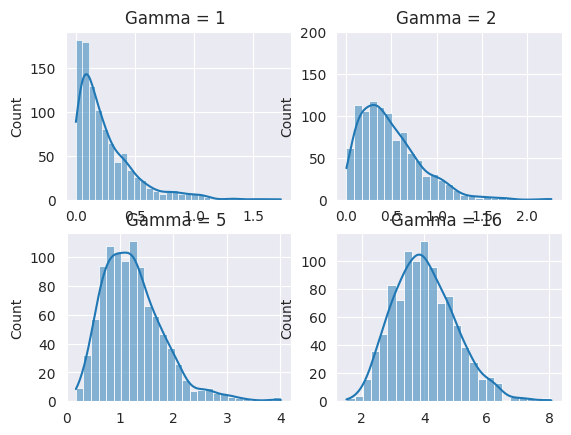

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import seaborn as sns
 
# generate standard gamma distribution of different Shape parameter
gamma_1  = np.random.gamma(1,0.25,size=1000)
gamma_2  = np.random.gamma(2,0.25,size=1000)
gamma_5 = np.random.gamma(5,0.25,size=1000)
gamma_10  = np.random.gamma(16,0.25,size=1000)
 
# plot different gamma distribution
sns.set_style('darkgrid')
fig, ax  = plt.subplots(2,2)
sns.histplot(gamma_1,kde=True,ax= ax[0,0] )
ax[0,0].set_title('Gamma = 1 ')
sns.histplot(gamma_2,kde=True, ax= ax[0,1], legend='Y=0.5')
ax[0,1].set_ylim([0,200])
ax[0,1].set_title('Gamma = 2 ')
sns.histplot(gamma_5,kde=True, ax= ax[1,0], legend='Y=5')
ax[1,0].set_title('Gamma = 5 ')
sns.histplot(gamma_10,kde=True, ax= ax[1,1], legend='Y=10')
ax[1,1].set_title('Gamma = 16 ')
plt.show()
 

## Back to TARnet

## Notation
**Causal identification**

- Observed covariates/features: $X$

- Potential outcomes: $Y(0)$ and $Y(1)$

- Treatment: $T$

- Unobservable Individual Treatment Effect: $\tau_i = Y_i(1) - Y_i(0)$

- Average Treatment Effect: $ATE =\mathbb{E}[Y_i(1)-Y_i(0)]= \mathbb{E}[{\tau_i}]$

- Conditional Average Treatment Effect: $CATE(x) =\mathbb{E}[Y_i(1)-Y_i(0)|X=x]$


**Deep learning estimation**

- Predicted outcomes: $\hat{Y}(0)$ and $\hat{Y}(1)$

- Outcome modeling functions: $\hat{Y}(T)=h(X,T)$ 

- Representation functions: $\Phi(X)$

- Propensity score function:
$\pi(X,T)=P(T|X)$ </br>*where $\pi(X,1)=P(T=1|X)$ and $\pi(X,0)=1-\pi(X,1)$* 

- Loss functions: $\mathcal{L}(true,predicted)$, with the mean squared error abbreviated $MSE$ and binary cross-entropy as $BCE$

- Estimated CATE<sup>*</sup>: $\hat{CATE_i} = \hat{\tau}_i = \hat{Y_i}(1)-\hat{Y_i}(0) = h(X,1)-h(X,0)$

- Estimated ATE: $\hat{ATE}=\frac{1}{n}\sum_{i=1}^n\hat{CATE_i}$

- Nearest-neighbor PEHE:
$$PEHE_{nn}=\frac{1}{N}\sum_{i=1}^N{(\underbrace{(1−2t_i)(y_i(t_i)−y_i^{nn}(1-t_i)}_{CATE_{nn}}−\underbrace{(h(\Phi(x),1)−h(\Phi(x),0)))}_{\hat{CATE}}}^2$$ for nearest neighbor $j$ of each unit $i$ in representation space such that $t_j\neq t_i$:
  $$y_i^{nn}(1-t_i) = \min_{j\in (1-T)}||\Phi(x_i|t_i)-\Phi(x_j|1-t_i)||_2$$

\* We define $\hat{\tau}_i = \hat{CATE_i}$ because the we lack the covariates to estimate the ITE.  

# Part 1: Coding up CFRNet using the MMD

Johansson et al. call the variant of TARNet with an IPM loss  Counterfactual Regression Network (CFRNet). Architecturally CFRNet is identical to TARNet, but the loss function looks like this:

\begin{equation}
\min_{h,\Phi,IPM}\frac{1}{n}\sum_{i=1}^n \mathcal{L}(h(\Phi(x_i),t_i),y_i) + \lambda \mathcal{R}(h)+\alpha\cdot IPM(\Phi(X,|T=1),\Phi(X|T=0))\end{equation}
where $\mathcal{R}(h)$ is a model complexity term and $\lambda$ and $\alpha$ are hyperparameters. $IPM(\Phi(X,|T=1),\Phi(X|T=0))$ is an IPM distance between the covariate distributions of the treated and control distributions after they are projected into representation space.

<figure><img src=https://github.com/kochbj/Deep-Learning-for-Causal-Inference/blob/main/images/CFRNet.png?raw=true width="900"><figcaption>CFRNet architecture introduced in Shalit et al., 2017. Purple indicates inputs, orange indicates network layers, other colors indicate output layers, and white indicates outputs. The dashes between colored shapes indicate an unspecifed number of additional hidden layers. The dashed lines on the right indicate non-gradient, plug-in computations that occur after training.</a></figcaption></figure>

In [3]:
import tensorflow as tf
import numpy as np 
import datetime #we'll use dates to label our logs
print(tf.__version__)

2.19.0


In [4]:
import urllib #Adapted for windows. Please use the corresponding eg  -GET if you are on different OS.
#import ssl --workaround for unverified_override

#ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
from sklearn.preprocessing import StandardScaler
train=urllib.request.urlretrieve("http://www.fredjo.com/files/ihdp_npci_1-100.train.npz","100.train.npz" )[0]
test=urllib.request.urlretrieve("http://www.fredjo.com/files/ihdp_npci_1-100.test.npz","100.test.npz" )[0]

In [6]:

 

def load_IHDP_data(training_data,testing_data,i=7):
    with open(training_data,'rb') as trf, open(testing_data,'rb') as tef:
        train_data=np.load(trf); test_data=np.load(tef)
        y=np.concatenate(   (train_data['yf'][:,i],   test_data['yf'][:,i])).astype('float32') #most GPUs only compute 32-bit floats
        t=np.concatenate(   (train_data['t'][:,i],    test_data['t'][:,i])).astype('float32')
        x=np.concatenate(   (train_data['x'][:,:,i],  test_data['x'][:,:,i]),axis=0).astype('float32')
        mu_0=np.concatenate((train_data['mu0'][:,i],  test_data['mu0'][:,i])).astype('float32')
        mu_1=np.concatenate((train_data['mu1'][:,i],  test_data['mu1'][:,i])).astype('float32')

        data={'x':x,'t':t,'y':y,'t':t,'mu_0':mu_0,'mu_1':mu_1}
        data['t']=data['t'].reshape(-1,1) #we're just padding one dimensional vectors with an additional dimension 
        data['y']=data['y'].reshape(-1,1)
        
        #rescaling y between 0 and 1 often makes training of DL regressors easier
        data['y_scaler'] = StandardScaler().fit(data['y'])
        data['ys'] = data['y_scaler'].transform(data['y'])

    return data

data=load_IHDP_data(training_data=train,testing_data=test)

## Creating a custom MMD loss

We'll begin by writing up MMD estimator described above in a custom loss object. The layer will take $\Phi$ and $T$ as inputs, and output $\hat{MMD^2}$. We'll implement the unbiased MMD estimator described above with the Guassian RBF function. 

# Exercise
Complete the return of the function cfr_loss

In [7]:
def pdist2sq(x,y):
    x2 = tf.reduce_sum(x ** 2, axis=-1, keepdims=True)
    y2 = tf.reduce_sum(y ** 2, axis=-1, keepdims=True)
    dist = x2 + tf.transpose(y2, (1, 0)) - 2. * x @ tf.transpose(y, (1, 0))
    return dist

from tensorflow.keras.losses import Loss

class CFRNet_Loss(Loss):
  #initialize instance attributes
  def __init__(self, alpha=1.,sigma=1.):
      super().__init__()
      self.alpha = alpha # balances regression loss and MMD IPM
      self.rbf_sigma=sigma #for gaussian kernel
      self.name='cfrnet_loss'
      
  def split_pred(self,concat_pred):
      #generic helper to make sure we dont make mistakes
      preds={}
      preds['y0_pred'] = concat_pred[:, 0]
      preds['y1_pred'] = concat_pred[:, 1]
      preds['phi'] = concat_pred[:, 2:]
      return preds

  def rbf_kernel(self, x, y):
    return tf.exp(-pdist2sq(x,y)/tf.square(self.rbf_sigma))

  def calc_mmdsq(self, Phi, t):
    Phic, Phit =tf.dynamic_partition(Phi,tf.cast(tf.squeeze(t),tf.int32),2)

    Kcc = self.rbf_kernel(Phic,Phic)
    Kct = self.rbf_kernel(Phic,Phit)
    Ktt = self.rbf_kernel(Phit,Phit)

    m = tf.cast(tf.shape(Phic)[0],Phi.dtype)
    n = tf.cast(tf.shape(Phit)[0],Phi.dtype)

    mmd = 1.0/(m*(m-1.0))*(tf.reduce_sum(Kcc))
    mmd = mmd + 1.0/(n*(n-1.0))*(tf.reduce_sum(Ktt))
    mmd = mmd - 2.0/(m*n)*tf.reduce_sum(Kct)
    return mmd * tf.ones_like(t)

  def mmdsq_loss(self, concat_true,concat_pred):
    t_true = concat_true[:, 1]
    p=self.split_pred(concat_pred)
    mmdsq_loss = tf.reduce_mean(self.calc_mmdsq(p['phi'],t_true))
    return mmdsq_loss

  def regression_loss(self,concat_true,concat_pred):
      y_true = concat_true[:, 0]
      t_true = concat_true[:, 1]
      p = self.split_pred(concat_pred)
      loss0 = tf.reduce_mean((1. - t_true) * tf.square(y_true - p['y0_pred']))
      loss1 = tf.reduce_mean(t_true * tf.square(y_true - p['y1_pred']))
      return loss0+loss1

  def cfr_loss(self, concat_true, concat_pred):
    lossR = self.regression_loss(concat_true, concat_pred)  # loss di regressione
    lossIPM = self.mmdsq_loss(concat_true, concat_pred)     # penalità MMD
    return lossR + self.alpha * lossIPM

      

  #compute loss
  def call(self, concat_true, concat_pred):        
      return self.cfr_loss(concat_true,concat_pred)

# Exercise
In this  implementation of TARnet we are using a simplified version of the Loss function that is found in Eq.3 of the Shalit paper. Confront the code with the math. There is something missing. What it is? 


## Metrics callback 


In [14]:
print(tf.__version__)

2.19.0


In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class Base_Metrics(Callback):
    def __init__(self,data, verbose=0):   
        super(Base_Metrics, self).__init__()
        self.data=data #feed the callback the full dataset
        self.verbose=verbose

        #needed for PEHEnn; Called in self.find_ynn
        self.data['o_idx']=tf.range(self.data['t'].shape[0])
        self.data['c_idx']=self.data['o_idx'][self.data['t'].squeeze()==0] #These are the indices of the control units
        self.data['t_idx']=self.data['o_idx'][self.data['t'].squeeze()==1] #These are the indices of the treated units
    
    def split_pred(self,concat_pred):
        preds={}
        preds['y0_pred'] = self.data['y_scaler'].inverse_transform(concat_pred[:, 0].reshape(-1, 1))
        preds['y1_pred'] = self.data['y_scaler'].inverse_transform(concat_pred[:, 1].reshape(-1, 1))
        preds['phi'] = concat_pred[:, 2:]
        return preds

    def find_ynn(self, Phi):
        #helper for PEHEnn
        PhiC, PhiT =tf.dynamic_partition(Phi,tf.cast(tf.squeeze(self.data['t']),tf.int32),2) #separate control and treated reps
        dists=tf.sqrt(pdist2sq(PhiC,PhiT)) #calculate squared distance then sqrt to get euclidean
        yT_nn_idx=tf.gather(self.data['c_idx'],tf.argmin(dists,axis=0),1) #get c_idxs of smallest distances for treated units
        yC_nn_idx=tf.gather(self.data['t_idx'],tf.argmin(dists,axis=1),1) #get t_idxs of smallest distances for control units
        yT_nn=tf.gather(self.data['y'],yT_nn_idx,1) #now use these to retrieve y values
        yC_nn=tf.gather(self.data['y'],yC_nn_idx,1)
        y_nn=tf.dynamic_stitch([self.data['t_idx'],self.data['c_idx']],[yT_nn,yC_nn]) #stitch em back up!
        return y_nn

    def PEHEnn(self,concat_pred):
        p = self.split_pred(concat_pred)
        y_nn = self.find_ynn(p['phi']) 
        cate_nn_err=tf.reduce_mean( tf.square( (1-2*self.data['t']) * (y_nn-self.data['y']) - (p['y1_pred']-p['y0_pred']) ) )
        return cate_nn_err

    def ATE(self,concat_pred):
        p = self.split_pred(concat_pred)
        return p['y1_pred']-p['y0_pred']

    def PEHE(self,concat_pred):
        #simulation only
        p = self.split_pred(concat_pred)
        cate_err=tf.reduce_mean( tf.square( ( (self.data['mu_1']-self.data['mu_0']) - (p['y1_pred']-p['y0_pred']) ) ) )
        return cate_err 

    def on_epoch_end(self, epoch, logs={}):
        concat_pred=self.model.predict(self.data['x'])
        #Calculate Empirical Metrics        
        ate_pred=tf.reduce_mean(self.ATE(concat_pred)); tf.summary.scalar('ate', data=ate_pred, step=epoch)
        pehe_nn=self.PEHEnn(concat_pred); tf.summary.scalar('cate_nn_err', data=tf.sqrt(pehe_nn), step=epoch)
        
        #Simulation Metrics
        ate_true=tf.reduce_mean(self.data['mu_1']-self.data['mu_0'])
        ate_err=tf.abs(ate_true-ate_pred); tf.summary.scalar('ate_err', data=ate_err, step=epoch)
        pehe =self.PEHE(concat_pred); tf.summary.scalar('cate_err', data=tf.sqrt(pehe), step=epoch)
        out_str=f' — ate_err: {ate_err:.4f}  — cate_err: {tf.sqrt(pehe):.4f} — cate_nn_err: {tf.sqrt(pehe_nn):.4f} — true_ate: {ate_true:.4f}'
        
        if self.verbose > 0: print(out_str)

## Building the model

Settings are close to the authors' recommended settings for IHDP.

# Exercise
Write the third layer (hint, it is already splitted in heads in the second layer, the third layer is the last one. Make sure to consider the output dim)

In [9]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model

def make_tarnet(input_dim, reg_l2):
    '''
    The first argument is the column dimension of our data.
    It needs to be specified because the functional API creates a static computational graph
    The second argument is the strength of regularization we'll apply to the output layers
    '''
    x = Input(shape=(input_dim,), name='input')

    # REPRESENTATION
    #in TF2/Keras it is idiomatic to instantiate a layer and pass its inputs on the same line unless the layer will be reused
    #Note that we apply no regularization to the representation layers
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_1')(x)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_2')(phi)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_3')(phi)

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_1')(phi)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_2')(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(y1_hidden)

    #a convenience "layer" that concatenates arrays as columns in a matrix
    concat_pred = Concatenate(1)([y0_predictions, y1_predictions])
    #the declarations above have specified the computational graph of our network, now we instantiate it
    model = Model(inputs=x, outputs=concat_pred)

    return model


In [10]:
data["x"]

array([[-0.65613806, -1.0024741 , -0.360898  , ...,  1.        ,
         0.        ,  0.        ],
       [-1.7153288 , -1.0024741 , -0.733261  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5543657 ,  0.19681813, -0.360898  , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.24543142, -0.20294595,  0.38382798, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.53274953,  0.5965822 , -1.105624  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.2830061 , -1.0024741 , -0.360898  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

 We're going to use ADAM as the optimizer since it was used in the paper.Batch size for the model should be adequately big, IPM is very unstable if the batch size is too small (i.e., there are no treated units in the batch).

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD, Adam
#Colab command to allow us to run Colab in TF2
%load_ext tensorboard 

val_split=0.2
batch_size=100
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)
yt = np.concatenate([data['ys'], data['t']], 1)

# Clear any logs from previous runs
!rm -rf ./logs/ 
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

#let's try ADAM this time
adam_callbacks = [
        TerminateOnNaN(),
        EarlyStopping(monitor='val_loss', patience=2, min_delta=0.),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                          min_delta=1e-8, cooldown=0, min_lr=0),
        tensorboard_callback,
        Base_Metrics(data,verbose=verbose)
    ]


cfrnet_model=make_tarnet(25,.01)
cfrnet_loss=CFRNet_Loss(alpha=1.0)

cfrnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                      loss=cfrnet_loss,
                 metrics=[cfrnet_loss,cfrnet_loss.regression_loss,cfrnet_loss.mmdsq_loss])

cfrnet_model.fit(x=data['x'],y=yt,
                 callbacks=adam_callbacks,
                  validation_split=val_split,
                  epochs=50,
                  batch_size=batch_size,
                  verbose=verbose)



Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  cfrnet_loss: 1.0649 - loss: 5.7773 - mmdsq_loss: 0.0733 - regression_loss: 
 — ate_err: 2.9121  — cate_err: 3.3110 — cate_nn_err: 3.7977 — true_ate: 3.8537
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - cfrnet_loss: 1.0351 - loss: 5.7452 - mmdsq_loss: 0.0722 - regression_loss: 0.9629 - val_cfrnet_loss: 1.2666 - val_loss: 5.8590 - val_mmdsq_loss: 0.2071 - val_regression_loss: 1.0595 - learning_rate: 1.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  cfrnet_loss: 0.8189 - loss: 5.4966 - mmdsq_loss: 0.0727 - regression_loss: 0.7
 — ate_err: 2.0537  — cate_err: 2.6072 — cate_nn_err: 3.1002 — true_ate: 3.8537
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - cfrnet_loss: 0.8109 - loss: 5.4875 - mmdsq_loss: 0.0722 - regression_loss: 0.7387 - val_cfrnet_loss: 1.1097 - val_loss: 5.6655 - val_mmdsq_loss: 0.2071 - val_regression_loss: 0.9026 - learning_rate: 1.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  cfrnet_loss: 0.6729 - loss: 5.

# Exercise
Predict one poit of your choice using the model that you have trained. The model should give you back 2 outputs, what are they? (hint, check carefully what the model is outputting...maybe you will notice more than 2 values in the output)

## Reviewing results in Tensorboard
When we run TensorBoard we notice a couple of things. First that with $\alpha=1$, the MMD IPM contributes only ~5-15% of the total gradient that the regression loss contributes, but grows over time to put an increasingly stronger penalty on the representations for not balancing the data. Whether we should use a bigger $\alpha$ is an empirical question for hyperparameter tuning.

The other thing you should notice is that while the IPM definitely shrinks initially, within a single batch it is VERY high variance due to the small batch size, and it's unclear whether it's making a difference. 

In [20]:
%tensorboard --logdir logs/fit



## Thanks
Most parts of this turorial were adapted based on the code and the work of:

(github.com/kochbj)  (bernardjkoch.com). 

In [21]:
input_dim=data['x'].shape[1]
x_test = np.random.rand(1, input_dim).astype(np.float32)

output = cfrnet_model.predict(x_test)

print("Output shape:", output.shape)
print("Output values:", output)

y0_pred = output[0, 0]
y1_pred = output[0, 1]

print(f"Predicted y0: {y0_pred}")
print(f"Predicted y1: {y1_pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Output shape: (1, 2)
Output values: [[0.1693907 1.3500991]]
Predicted y0: 0.1693906933069229
Predicted y1: 1.3500990867614746
